<a href="https://colab.research.google.com/github/mazzulab/ssm/blob/master/notebooks/2c%20Input-driven%20linear%20model%20(LM-HMM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Installing repo and dependencies if using colab (restart Colab Runtime after installing). Skip to imports if running locally.

!pip install -U matplotlib &> /dev/null
!git clone https://github.com/mazzulab/ssm &> /dev/null
!pip install git+https://github.com/mazzulab/ssm.git &> /dev/null
!git clone https://github.com/mazzulab/dyn_sys_tutorial &> /dev/null
!pip install git+https://github.com/mazzulab/dyn_sys_tutorial.git &> /dev/null

1. Load mystery 2d dataset of $(R_i,F_i)$ pairs, for $i=1,\ldots,N$.

2. Fit a Linear Model (LM)

3. Fit mixture of K Linear Models (MLM)
- Find the best K for MLM (model selection)
- Cross-validation
- BIC, AIC criteria

5. Is there a long timescale in the dataset?

6. Hidden Markov model with Linear Model emissions (LM-HMM)
- Generative mode: instantiate model with K=3 states, set model parameters, sample data from synthetic model
- Parameter recovery
- Model selection: find the best K that fits ground truth (K=3) 

4. Fit LM-HMM to mystery data
- Model selection: Find best K that fits mystery data
- Fit model to data
- compare LM, MLM, LM-HMM

# Generate mystery data

In [0]:
import utils_tutorial
import matplotlib.pyplot as plt
import numpy as np
import pickle
np.random.seed(2)
import autograd.numpy as np
import autograd.numpy.random as npr
import ssm # note this should be the forked ssm repo above
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
%matplotlib inline
import seaborn as sns
sns.set_style("white")
sns.set_context("talk")
color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]
colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)
from ssm import utilplot

# Speficy whether or not to save figures
save_figures = True

%load_ext autoreload
%autoreload 1

obs, inpt, mystery_model,true_labels = utils_tutorial.mysteryData()
data={'inpt':inpt, 'obs':obs}

# Save the dictionary
with open('mysteryData.pkl', 'wb') as f: pickle.dump(data, f)


## Fit a Linear Model (LM)

- estimate hold-out R2 (cross-validation)

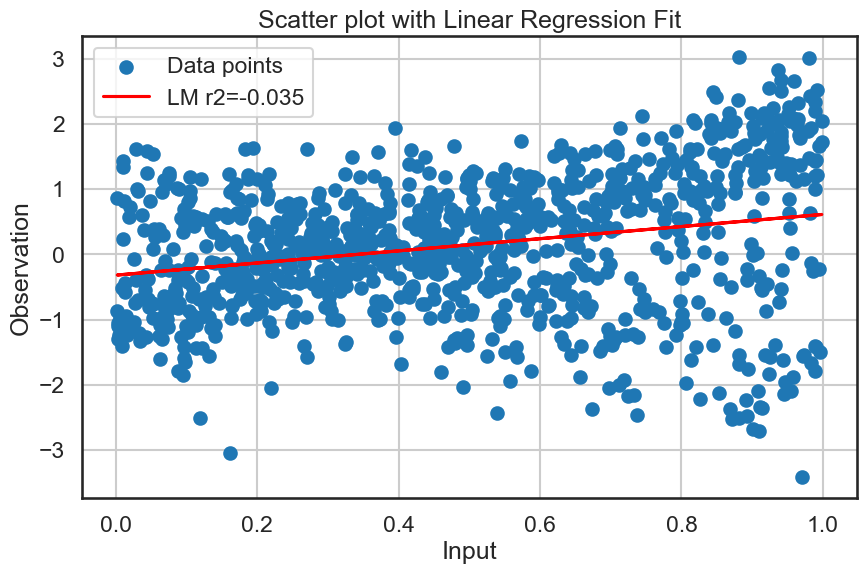

In [1]:


with open('mysteryData.pkl', 'rb') as file:
    new_data = pickle.load(file)

# Unpacking the new data
inpt_new = new_data['inpt']
obs_new = new_data['obs']

# Fit a simple linear regression model
X_new = inpt_new
y_new = obs_new
model_new = LinearRegression()

model_tot = LinearRegression()
model_tot.fit(X_new, y_new)
y_pred=model_tot.predict(X_new)
r2_new=model_tot.score(y_pred, y_new)

# Scatter plot of the data and the linear regression model
plt.figure(figsize=(10, 6))
plt.scatter(X_new, y_new, label='Data points')
plt.plot(X_new, model_tot.predict(X_new), color='red', label=f'LM r2={r2_new:.3f}')
plt.xlabel('Input')
plt.ylabel('Observation')
plt.title('Scatter plot with Linear Regression Fit')
plt.legend()
plt.grid(True)
plt.show()

## Fit a mixture of linear regressions

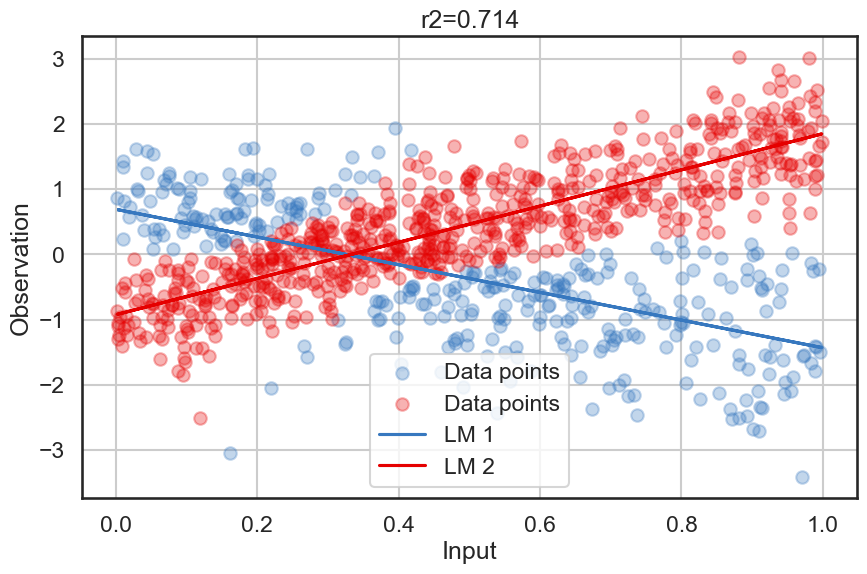

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
n_components=2
# Load the provided data
file_path_new = 'mysteryData.pkl'
with open(file_path_new, 'rb') as file:
    new_data = pickle.load(file)

# Unpack the new data
inpt_new = np.ravel(new_data['inpt'])
obs_new = np.ravel(new_data['obs'])

# Reshape the data
X = inpt_new.reshape(-1, 1)
y = obs_new

# Fit the model to the generated data
model = utils_tutorial.MixtureOfLinearRegressions(n_components=n_components)
model.fit(X, y)
predictions = model.predict(X,y)
r2_mlm = r2_score(y, predictions)

# Predict labels for each data point
labels_em = model.predict_labels(X,y)

# Scatter plot of the data with EM components and fitted lines
plt.figure(figsize=(10, 6))
for i in range(n_components):
    plt.scatter(X[labels_em==i], y[labels_em==i], color=colors[i],alpha=0.3, label='Data points')
plt.xlabel('Input')
plt.ylabel('Observation')
plt.title('Scatter plot with Mixture of Linear Regressions using EM')

# Overlay the fitted lines
for i, lin_model in enumerate(model.em_algorithm.models_):
    plt.plot(X, lin_model.predict(X), color=colors[i], label=f'LM {i+1}')
plt.title(f'r2={r2_mlm:.3f}')
plt.legend()
plt.grid(True)
plt.show()


## Find best number of hidden states

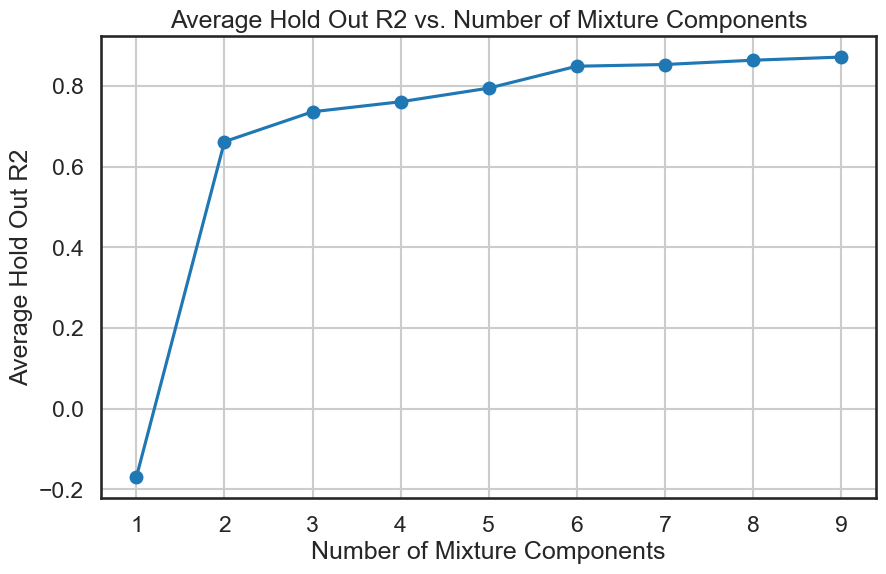

The best number of mixture components is 2


In [3]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from joblib import Parallel, delayed


def cross_validate_model(n_components, X, y, kf):
    r2_scores_em = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model_cv = utils_tutorial.MixtureOfLinearRegressions(n_components=n_components)
        model_cv.fit(X_train, y_train)
        predictions_test = model_cv.predict(X_test,y_test)

        r2_score_fold = r2_score(y_test, predictions_test)
        r2_scores_em.append(r2_score_fold)
    
    return np.mean(r2_scores_em)

# Perform cross-validated model selection to find the best number of mixture components
component_range = range(1, 10)
kf = KFold(n_splits=5)

mean_cv_r2_scores = Parallel(n_jobs=-1)(delayed(cross_validate_model)(n_components, X, y, kf) for n_components in component_range)

# Plot the average hold out R2 as a function of the mixture components
plt.figure(figsize=(10, 6))
plt.plot(component_range, mean_cv_r2_scores, marker='o')
plt.xlabel('Number of Mixture Components')
plt.ylabel('Average Hold Out R2')
plt.title('Average Hold Out R2 vs. Number of Mixture Components')
plt.grid(True)
plt.show()

mean_cv_r2_scores

best_k=utils_tutorial.find_elbow_point(mean_cv_r2_scores)
print(f'The best number of mixture components is {best_k}')


## Plot time series of observations

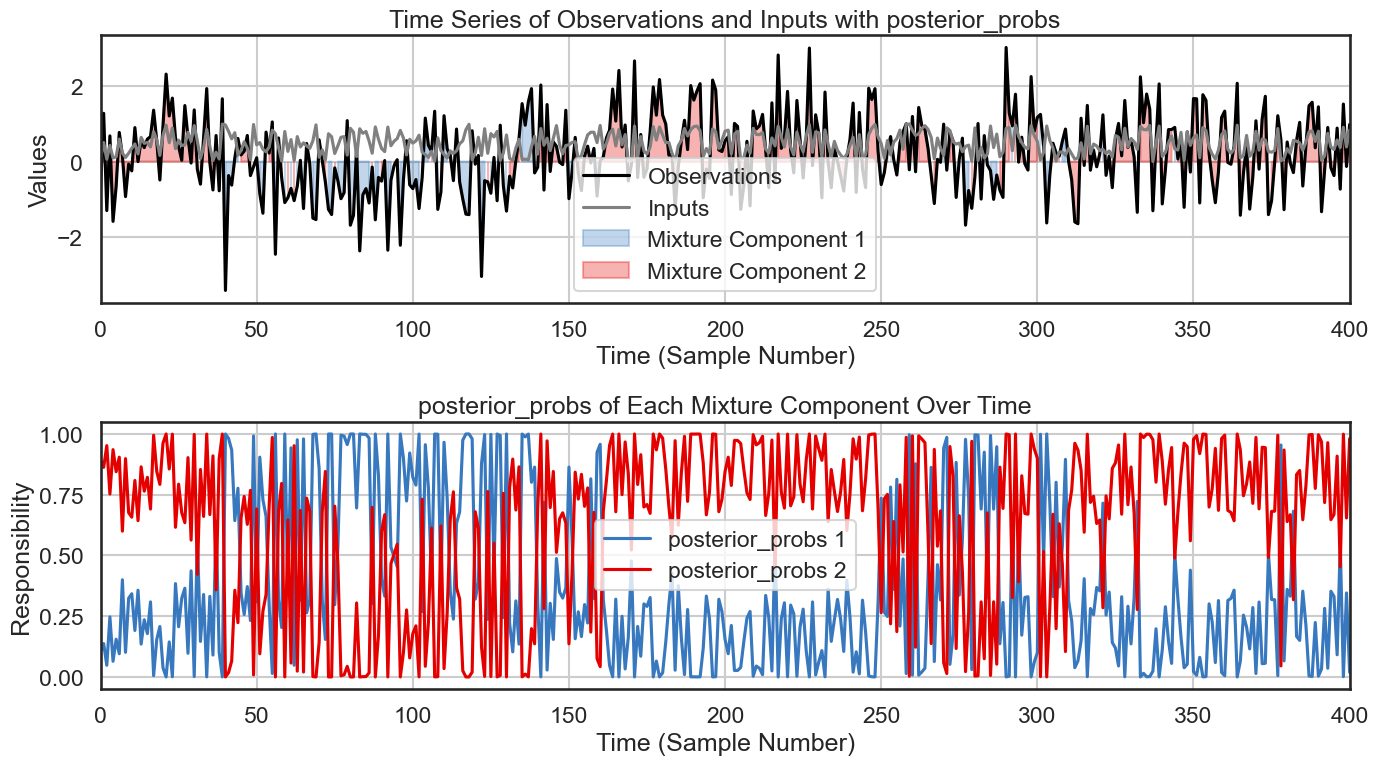

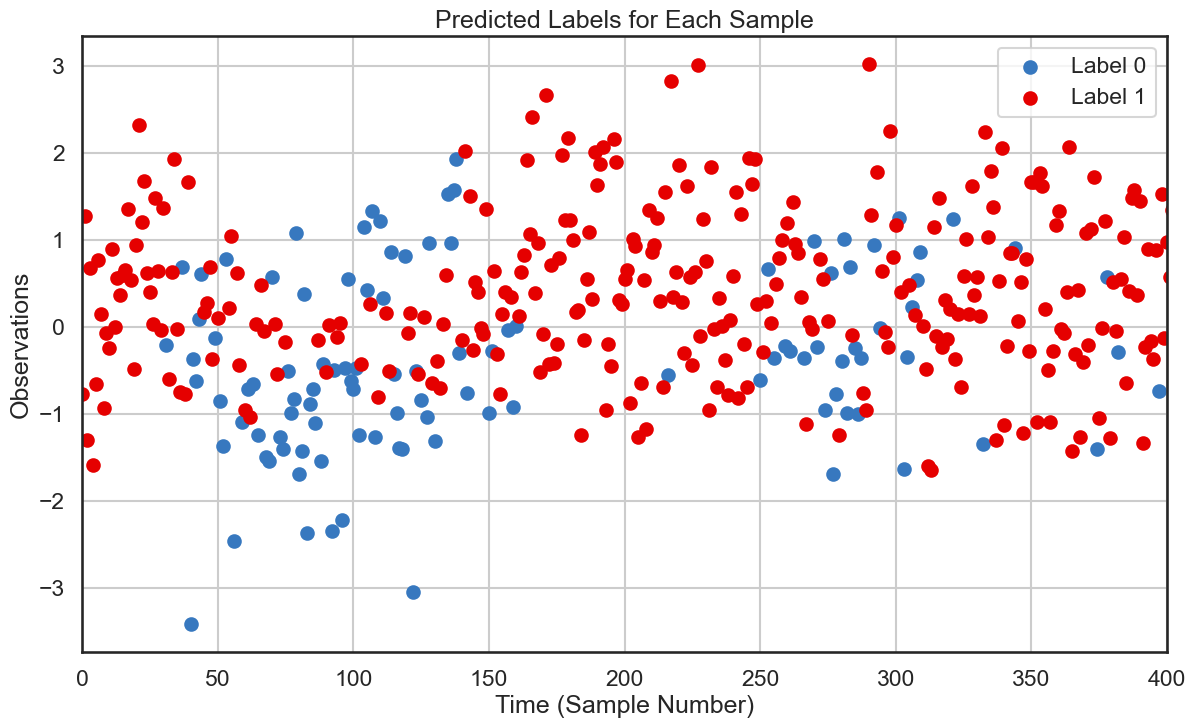

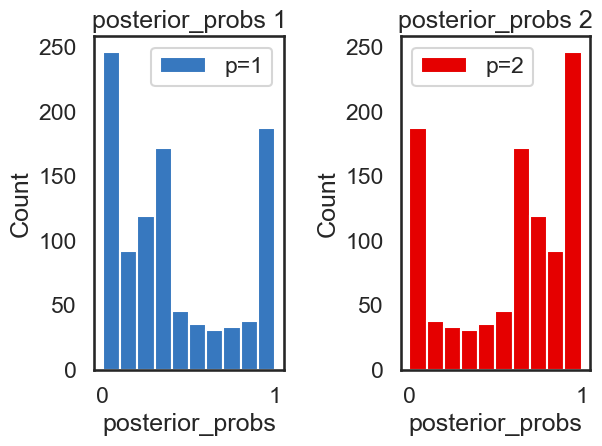

In [4]:
# Fit the model to the generated data
n_components=best_k
model = utils_tutorial.MixtureOfLinearRegressions(n_components=n_components)
model.fit(X, y)

# Predict responsibilities and labels
responsibilities = model.em_algorithm.responsibilities_
posterior_probs=responsibilities
predicted_labels = model.predict_labels(X,y)
xlim=400
# Plot the time series of the data (obs and inputs)
plt.figure(figsize=(14, 8))
n_samples = len(y)
# Plot observations and inputs
plt.subplot(2, 1, 1)
plt.plot(range(n_samples), y, label='Observations', color='black')
plt.plot(range(n_samples), X.flatten(), label='Inputs', color='gray')

for i in range(n_components):
    plt.fill_between(range(n_samples), y, where=(posterior_probs[:, i] > 0.5), color=colors[i], alpha=0.3, label=f'Mixture Component {i+1}')

plt.xlabel('Time (Sample Number)')
plt.ylabel('Values')
plt.title('Time Series of Observations and Inputs with posterior_probs')
plt.xlim(0,xlim)

plt.legend()
plt.grid(True)

# Plot posterior_probs
plt.subplot(2, 1, 2)
for i in range(n_components):
    plt.plot(range(n_samples), posterior_probs[:, i], label=f'posterior_probs {i+1}', color=colors[i])

plt.xlabel('Time (Sample Number)')
plt.ylabel('Responsibility')
plt.title('posterior_probs of Each Mixture Component Over Time')
plt.xlim(0,xlim)

plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualize the predicted labels

plt.figure(figsize=(14, 8))
indplot = np.arange(n_samples)
for i in range(n_components):
    mask = (predicted_labels == i)
    plt.scatter(indplot[mask], y[mask], color=colors[i], label=f'Label {i}')
plt.xlabel('Time (Sample Number)')
plt.ylabel('Observations')
plt.title('Predicted Labels for Each Sample')
plt.xlim(0,xlim)

plt.legend()
plt.grid(True)
plt.show()

for i in range(posterior_probs.shape[1]):
    plt.subplot(1,posterior_probs.shape[1],  i+1)
    plt.hist(posterior_probs[:, i], color=colors[i], label=f'p={i+1}')
    plt.legend()
    plt.title(f'posterior_probs {i+1}')
    plt.xlabel('posterior_probs'); plt.ylabel('Count')

plt.tight_layout()
plt.show()


## Plot autocorrelation of time series

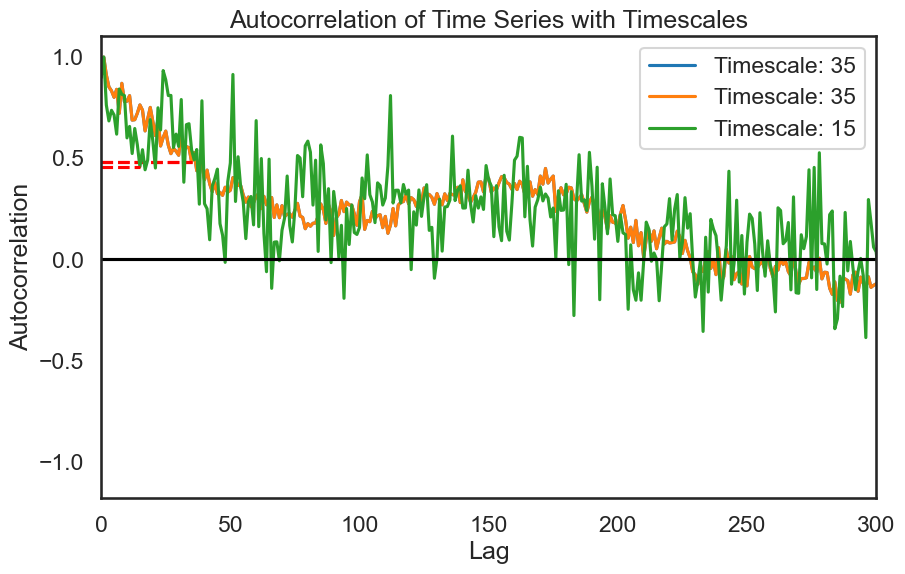

<Figure size 640x480 with 0 Axes>

In [5]:
fig=plt.figure(figsize=(10, 6))
xlim=300
timescale = []
for i in range(n_components):
          y_acf=utils_tutorial.autocovariance(responsibilities[:,i])
          y_acf=y_acf[1:]/np.max(y_acf[1:])
          timescale.append( int(utils_tutorial.compute_hwhm(y_acf)))
          plt.plot(y_acf, label=f"Timescale: {timescale[i]}")
          plt.axhline(y_acf[timescale[i]], xmin=0, xmax=(timescale[i])/xlim, color='red', linestyle='--')
y_acf=utils_tutorial.autocovariance(y)
y_acf=y_acf[1:]/np.max(y_acf[1:])
timescale.append( int(utils_tutorial.compute_hwhm(y_acf)))
plt.plot(y_acf, label=f"Timescale: {timescale[i+1]}")
plt.axhline(y_acf[timescale[i+1]], xmin=0, xmax=(timescale[i+1])/xlim, color='red', linestyle='--')
plt.axhline(0, color='black')
plt.legend()
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Time Series with Timescales")
plt.xlim([0, xlim])
plt.show()
plt.savefig('AutocorrTimescales.png')

# Hidden Markov model

**LM-HMM with input-driven Gaussian emissions** 

*This notebook demonstrates the model published in [(Cazettes et al., Nat. Neuro. 2023)](https://www.nature.com/articles/s41593-023-01305-8) and was prepared by Luca Mazzucato (University of Oregon). It is part of this [forked ssm repo](https://github.com/mazzulab/ssm/blob/master/notebooks/2c%20Input-driven%20linear%20model%20(LM-HMM).ipynb). Part of the code is adapted from [`2b Input Driven Observations (GLM-HMM)`](https://github.com/mazzulab/ssm/blob/master/notebooks/2b%20Input%20Driven%20Observations%20(GLM-HMM).ipynb), by [(Ashwood et al., Nat. Neuro. 2022)](https://www.nature.com/articles/s41593-021-01007-z).  Please ask questions at lmazzuca at uoregon dot edu.*

In order to run this notebook, please install the conda environment [`ssm_conda_mazzu`](https://github.com/mazzulab/AppliedMathNotebooks/blob/main/setup_conda_env_ssm_conda.sh).

Let us start from a simple linear model (LM) where some dependent variables $y_i$ (the observations, $i=1,\ldots,D=$`obs_dim`) are generated from some dependent variables $x_m$ (the inputs, $m=1,\ldots,M=$`input_dim`) based on a linear relationship (corresponding to a gaussian multivariante regression) 
$$
y_i=\sum_{m=1}^M W^{(k)}_{im}x_m+\mu^{(k)}_i+\epsilon_i^{(k)}
$$
with regression coefficients $(W^{(k)}_{im},\mu^{(k)}_i)$ and gaussian noise $\epsilon_i\sim{\it N}(0,\Sigma^{(k)}_{ij})$, with noise covariance $\Sigma_{ij}$. In the case $k=1$, we have only one set of regression coefficients and $(W^{(k)},\mu^{(k)})$ and this corresponds to the standard linear regression problem.

Now let us assume that the dependence of $y$ on $x$ varies with time and takes values among a discrete set of $k=1,\ldots,K=$=`num_states` different gaussian LMs, which evolve according to an underlying Markov chain. Each LM consists of the parameter set $(W^{(k)}_{im},\mu^{(k)}_i,\Sigma^{(k)}_{ij})$, and the switching dynamics between the different LMs are governed by the underlying transition probability matrix $A_{kl}$. This is an LM-HMM with multivariate Gaussian emissions. The total set of parameters includes also the initial probabilities for each state $\pi^{(k)}$.

In [6]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(3)

import ssm # note this should be the forked ssm repo above
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

from ssm import utilplot

# Speficy whether or not to save figures
save_figures = True

## 1. Generate LM-HMM observations ##

### 1.a Specify parameters of the ground truth LM-HMM

Here we generate observations from an LM-HMM `true_hmm` with `input_dim` dimensional inputs, `obs_dim` dimensional observations, and `num_states` hidden states. We choose specific ground truth values of the model parameters $(W^{(k)}_{im},\mu^{(k)}_i,\Sigma^{(k)}_{ij})$ which can be set to the variables `true_hmm.observations.Wks`, `true_hmm.observations.mus`, and `true_hmm.observations.Sigmas`, respectively. We choose the values of the transition probabilities $A_{kl}$ between hidden states as well by setting the log of the transition probability matrix `true_hmm.transitions.log_Ps`.


In [77]:
# Set the parameters of the HMM
time_bins = 1000   # number of time bins
num_states = 3    # number of discrete states
obs_dim = 1       # dimensionality of observation
input_dim=1     # input dimension

# Create an HMM
true_hmm = ssm.HMM(num_states, obs_dim, M=input_dim,observations="input_driven_obs_gaussian", transitions="standard")
# set weights Wk, biases mus, and noise covariance sigmas by hand

np.random.seed(0)
# gen_weights=2*np.ones((num_states,obs_dim,input_dim))
# gen_weights[0]=-2*gen_weights[0]
# gen_weights[1]=0
gen_weights=np.random.randn(num_states,obs_dim,input_dim)

# mus=10*np.ones((num_states, obs_dim))
# mus[0]=-mus[0]
mus=np.random.randn(num_states, obs_dim)

stdnoise=1
sigma=stdnoise**2*np.eye(obs_dim) # diagonal noise correlations with variance stdnoise**2
sigmas = np.dstack([sigma]*num_states).transpose((2,0,1))

true_hmm.observations.mus = mus
true_hmm.observations.Sigmas = sigmas
true_hmm.observations.Wks =  2*gen_weights

# set transition probabilities as well
trans_eps=0.02 # off diag transition prob to another state
trans0=trans_eps*np.ones((num_states,num_states))
for i in range(num_states):
    trans0[i,i]=1-(trans_eps*(num_states-1))   
true_hmm.transitions.log_Ps=np.log(trans0)
print('trans\n',trans0)
print('mus\n',mus)
print('Wks\n',gen_weights)
print('Sigmas\n',sigmas)



trans
 [[0.96 0.02 0.02]
 [0.02 0.96 0.02]
 [0.02 0.02 0.96]]
mus
 [[ 2.2408932 ]
 [ 1.86755799]
 [-0.97727788]]
Wks
 [[[1.76405235]]

 [[0.40015721]]

 [[0.97873798]]]
Sigmas
 [[[1.]]

 [[1.]]

 [[1.]]]


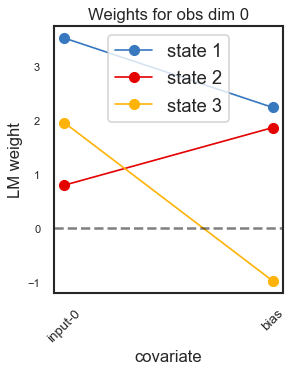

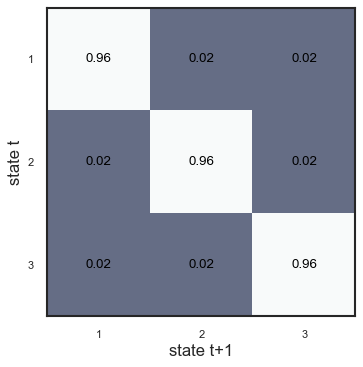

In [78]:
# Plot generative parameters:
mus=true_hmm.observations.mus
gen_weights=true_hmm.observations.Wks

utilplot.plot_weights(gen_weights,mus)
if save_figures:
    plt.savefig("hmm_params.pdf")
    
fig = plt.figure(figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
utilplot.plot_trans_matrix(trans0)
if save_figures:
    plt.savefig("hmm_trans.pdf")

### 1.b Sample data from the LM-HMM

Sample data from the LM-HMM. We create arrays of dimension (`time_bins`,`input_dim`) representing the dependent variables $x_i$, or inputs to the LM-HMM. We will generate a linearly varying input in all dimensions with slope 0.1.  

In [79]:
# Create an exogenous input dim T x M
inpt = np.random.rand(time_bins) # generate random inputs from uniform distribution
# inpt = 0.1*(np.arange(time_bins)+1) # generate linearly increasing input for a simpler model
if inpt.ndim == 1: # if input is vector of size self.M (one time point), expand dims to be (1, M)
    inpt = np.expand_dims(inpt, axis=1)
inpt=np.tile(inpt,input_dim)

# Sample some data from the HMM
true_states, obs = true_hmm.sample(time_bins, input=inpt)
true_ll = true_hmm.log_likelihood(obs,inputs=inpt)

Below, we first plot the samples generated from the LM-HMM, along the first dimension of input and output, color-coded according to the underlying state. The thin gray lines trace the latent variable as it transitions from one state to another.

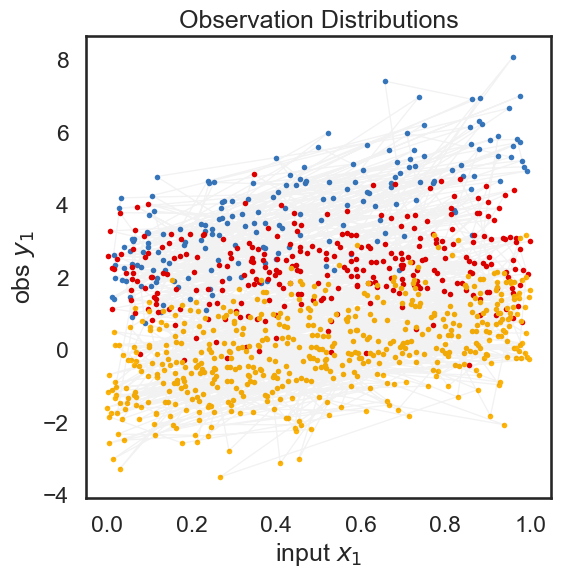

In [80]:
plt.figure(figsize=(6, 6))
for k in range(num_states):
#     plt.contour(X/X, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]))
    plt.plot(inpt[true_states==k,0], obs[true_states==k, 0], 'o', mfc=colors[k], mec='none', ms=4)
    
plt.plot(inpt[:,0], obs[:,0], '-k', lw=1, alpha=.05)
plt.xlabel("input $x_1$")
plt.ylabel("obs $y_1$")
plt.title("Observation Distributions")

if save_figures:
    plt.savefig("hmm_1.pdf")

## 2. Fit LM-HMM and perform recovery analysis

### 2a. Maximum Likelihood Estimation
Now we instantiate a new LM-HMM `mle_hmm` and fit it to the simulated data to recover the ground truth parameters. We will perform a Maximum Likelihood Estimation (MLE) using the Expectation Maximization (EM) algorithm at first.

  0%|          | 0/100 [00:00<?, ?it/s]

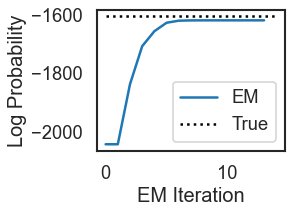

In [81]:
mle_hmm = ssm.HMM(num_states, obs_dim, M=input_dim, observations="input_driven_obs_gaussian", transitions="standard")

N_iters = 100 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = mle_hmm.fit(obs, inputs=inpt, method="em", num_iters=N_iters, tolerance=10**-4)

# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
plt.plot([0, len(fit_ll)], (true_ll) * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
# plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.tight_layout()

if save_figures:
    plt.savefig("hmm_EM_LL.pdf")

### 2b. Retrieved parameters

Compare retrieved weights and transition matrices to generative parameters. To do this, we use the 'most_likely_states method' to infer the most likely latent states given the observations and our model fit (this uses the Viterbi algorithm). Then we find the best permutation of the sequence of 'most_likely_states' from the fit that best correlates with the true state sequence generated from the true generative model.  One way to do this uses the `find_permutation` function from `ssm`:

In [82]:
most_likely_states=mle_hmm.most_likely_states(obs, input=inpt)
mle_hmm.permute(find_permutation(true_states, most_likely_states))

Now plot generative and retrieved weights for LMs

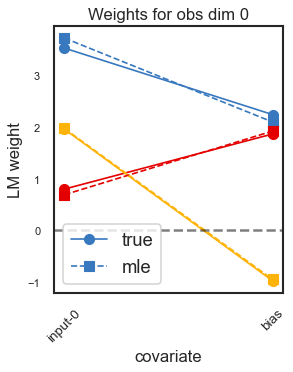

In [83]:
# Plot generative parameters:
mus=true_hmm.observations.mus
gen_weights=true_hmm.observations.Wks
recovered_weights = mle_hmm.observations.Wks
recovered_mus=mle_hmm.observations.mus

weight_dic={}; weight_dic[0]={}; weight_dic[1]={}; 
weight_dic[0]['weights']=gen_weights; weight_dic[0]['mus']=mus; weight_dic[0]['label']='true'; 
weight_dic[1]['weights']=recovered_weights; weight_dic[1]['mus']=recovered_mus; weight_dic[1]['label']='mle'; 
utilplot.plot_weights_comparison(weight_dic)


Now plot generative and retrieved transition matrices

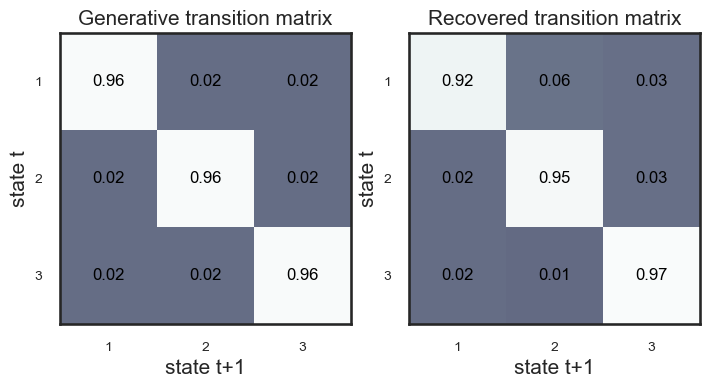

In [84]:
gen_trans_mat = np.exp(true_hmm.transitions.log_Ps)
recovered_trans_mat = np.exp(mle_hmm.transitions.log_Ps)

plt.subplot(1, 2, 1)
utilplot.plot_trans_matrix(gen_trans_mat)
plt.title("Generative transition matrix", fontsize = 15)

plt.subplot(1, 2, 2)
utilplot.plot_trans_matrix(recovered_trans_mat)
plt.title("Recovered transition matrix", fontsize = 15)

utilplot.plt.subplots_adjust(0, 0, 1, 1)


### 2c. Posterior State Probabilities

Let's now plot $p(z_{t} = k|\mathbf{y}, \{u_{t}\}_{t=1}^{T})$, the posterior state probabilities, which give the probability of the animal being in state k at trial t.

true
mle


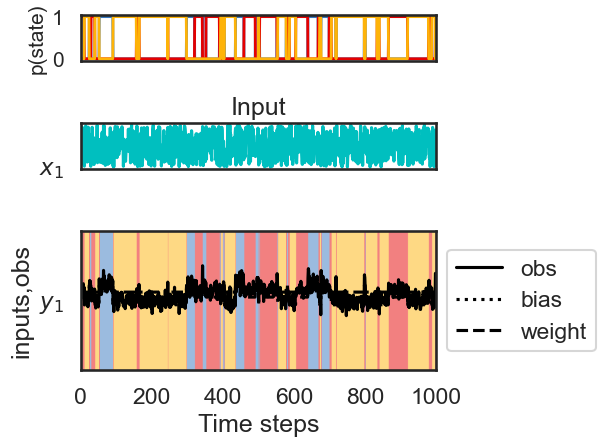

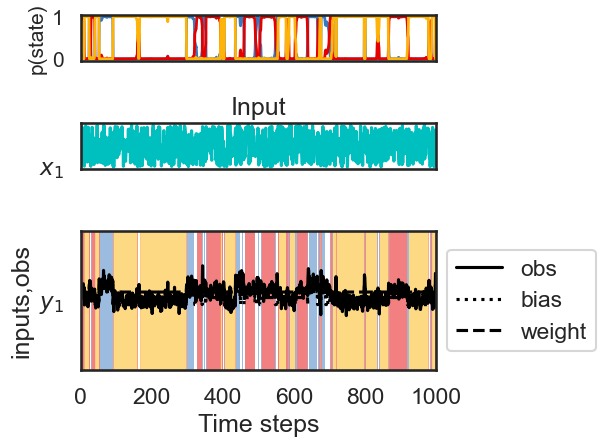

In [85]:
# Get expected states:
posterior_probs = mle_hmm.expected_states(data=obs, input=inpt)[0]
posterior_probs0 = np.zeros((true_states.size, true_states.max() + 1))
posterior_probs0[np.arange(true_states.size), true_states] = 1


print('true')
fig=utilplot.plot_postprob_obs(posterior_probs0,obs,inpt,true_hmm,colors,cmap)
fig=plt.tight_layout()
if save_figures:
    plt.savefig("hmm_trial_true.pdf")
print('mle')
fig=utilplot.plot_postprob_obs(posterior_probs,obs,inpt,mle_hmm,colors,cmap)
fig=plt.tight_layout()
if save_figures:
    plt.savefig("hmm_trial_recover.pdf")

### 3b. Stratification for cross-validation

Stratified folds are created as follows. Each fold contains data from all sessions. Within each session, we split the data into `nKfold` folds, each fold containing consecutive intervals of data. We then collect all intervals corresponding to fold n.1 from all sessions and concatenate it into fold n.1; same for fold n.2, and so on. Each fold now contains data from all sessions. This is achieved with the function `StratifiedKFold`.

### 3c. Cross-validation function

We define a function that takes training and test sets for each fold, and fits to the training set two LM-HMMs with fixed number of states `num_states`, one using MLE and one using MAP. Then it evaluates the log-likelihood of the test set given MLE and MAP fits. This function takes dictionaries as inputs and returns dictionaries as output.

Now we run the nested cross-validation loop over:
- `nKfold` cross-validation folds, stratified as above.
- Increasing number of hidden states from $k=1,\ldots,$`max_states`. 
- For each fold and each value of hidden states $k$, we fit several `nRunEM` models, each one starting from random initialization of model parameter, to avoid getting stuck in a single local maximum of the likelihood.

The code is iterating over `nKfold` normally, but it is parallelized over `max_states`*`nRunEM` to optimize performance. The parallel job is called with:
```python
results = Parallel(n_jobs=NumThread)(
        delayed(xval_func)(data_in, num_states0)
        for iRun,num_states0 in zip(RunN,stN))
```
where `NumThread` is the number of simultaneous jobs we are running, equal to the number of Threads we pick. It is best to not utilize all the cores at disposal on the current machine, but to leave a couple for normal operations. This code runs `xval_func` in parallel, each one using the same `data_in` fold, but iterating over different number of hidden states `num_states0`$=1,\ldots,`max_states`; and `nRunEM` times to deal with local maxima. 

In [89]:
#Create kfold cross-validation object which will split data for us
ntrials=len(obs)
synthetic_data=obs
synthetic_inpts=inpt

nKfold=5
kf = KFold(n_splits=nKfold)
max_states = 5 # largest number of states allowed in the model selection
N_iters = 100 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
TOL=10**-4 # tolerance parameter (see N_iters)
nRunEM=4 # # of times we run EM for each choice of number of states
# NumThread=20
# initialized training and test loglik for model selection, and BIC
ll_training = np.zeros((max_states,nKfold,nRunEM))
ll_heldout = np.zeros((max_states,nKfold,nRunEM))
ll_training_map = np.zeros((max_states,nKfold,nRunEM))
ll_heldout_map = np.zeros((max_states,nKfold,nRunEM))

stN=np.flip(np.tile(np.arange(1,max_states+1),nRunEM))
RunN=np.repeat(np.arange(1,nRunEM+1),max_states,axis=0) 


# xval is over cv loops, states, and runs
for iK, (train_index, test_index) in enumerate(kf.split(synthetic_data)):
    nTrain = len(train_index); nTest = len(test_index)#*obs_dim
    data_in={'training_data':synthetic_data[train_index],'test_data':synthetic_data[test_index],
              'training_inpts':synthetic_inpts[train_index],'test_inpts':synthetic_inpts[test_index],
              'N_iters':N_iters,'TOL':TOL}
    results = Parallel(-1)(
        delayed(utils_tutorial.xval_func)(data_in, num_states0)
        for iRun,num_states0 in zip(RunN,stN))
    # unpack
    for i in range(max_states*nRunEM):
        ll_training[stN[i]-1,iK,RunN[i]-1]=results[i]['ll_training']
        ll_heldout[stN[i]-1,iK,RunN[i]-1]=results[i]['ll_heldout']
        ll_training_map[stN[i]-1,iK,RunN[i]-1]=results[i]['ll_training_map']
        ll_heldout_map[stN[i]-1,iK,RunN[i]-1]=results[i]['ll_heldout_map']

LP: -1353.0: 100%|██████████| 100/100 [00:05<00:00, 17.05it/s]


### 3d. Information criteria

Here we run the BIC and AIC criteria for model selection, which are Bayesian model selection procedure which do not involve cross-valdation. Here, for each value of the hidden states $K$, we fit `nRunEM` different LM-HMMs with MLE, and estimate the average total log-likelihood of the data $LL$ across the `nRunEM` runs. We then plot the $BIC = S*\ln(T) - 2 LL$, and $AIC = 2*S - 2 LL$ where S is the # of parameters of the model and T is the # of data points. The number of parameters in the model are:
- $K(K-1)$ from the transition matrix.
- $K-1$ from the initial state distribution.
- $K(D*M+D)$ from $W,\mu$.
- $K*D$ from a diagonal noise distribution (our default option); or $K*D(D+1)/2$ for a full noise covariance matrix. 

In our case then $S=(K+1)(K-1)+K(D*M+2D)$.

In general, AIC is a good model selection criterion in the regime of large sample size, and BIC works better for less data.

In [87]:
# BIC model selection
def single_func(synthetic_data,synthetic_inpts):
        xval_hmm = ssm.HMM(num_states, obs_dim, M=input_dim, 
                observations="input_driven_obs_gaussian", transitions="standard")
        hmm_lls = xval_hmm.fit(synthetic_data, inputs=synthetic_inpts, method="em", num_iters=N_iters, tolerance=TOL)        
        out=xval_hmm.log_likelihood(synthetic_data,inputs=synthetic_inpts)
        return out
#Number of parameters for the model: (transition matrix) + (mean values for each state) + (covariance matrix for each state)
time_bins=len(synthetic_data) # total number of licks
BIC = np.zeros((max_states,nRunEM))
AIC = np.zeros((max_states,nRunEM))
for iS, num_states in enumerate(range(1,max_states+1)):
    K = (num_states+1)*(num_states-1) + num_states*(obs_dim*input_dim+2*obs_dim)
    results = Parallel(-1)(
        delayed(single_func)(synthetic_data, synthetic_inpts)
        for iRun in range(nRunEM))
    for iRun in range(nRunEM):
        BIC[iS,iRun] = K*np.log(time_bins) - 2*results[iRun]        
        AIC[iS,iRun] = K*2 - 2*results[iRun]        


LP: -1628.7: 100%|██████████| 100/100 [00:05<00:00, 19.15it/s]


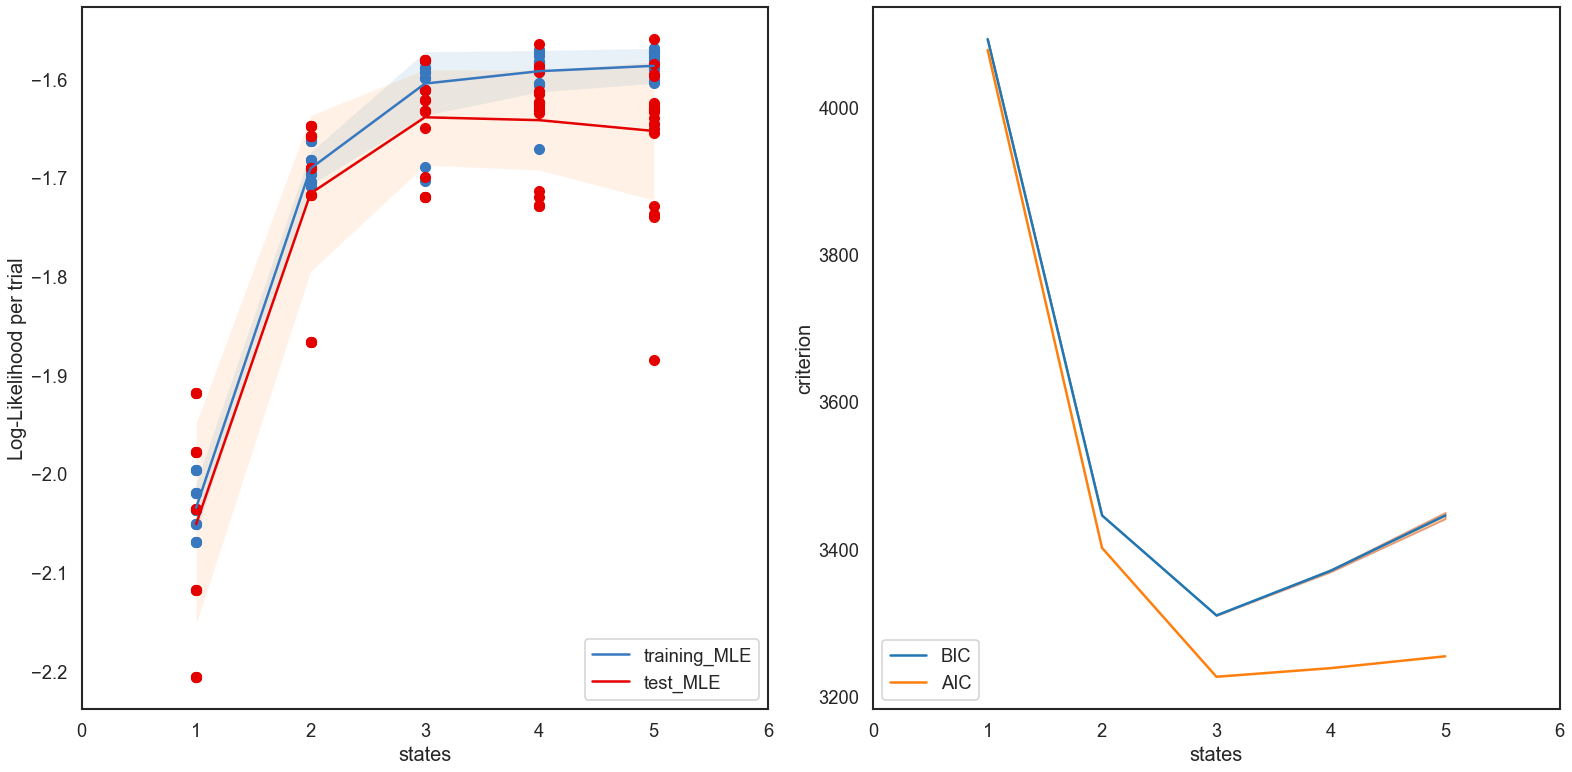

In [91]:
from scipy.interpolate import interp1d
kindspline='quadratic'
# Plot the xval loglik 
fig = plt.figure(figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)

# reshape variables for plot
ll_training_plot = ll_training.reshape(max_states,nKfold*nRunEM)
ll_heldout_plot = ll_heldout.reshape(max_states,nKfold*nRunEM)
ll_training_map_plot = ll_training_map.reshape(max_states,nKfold*nRunEM)
ll_heldout_map_plot = ll_heldout_map.reshape(max_states,nKfold*nRunEM)


for iS, num_states in enumerate(range(1,max_states+1)):
    plt.plot((iS+1)*np.ones(nKfold*nRunEM),ll_training_plot[iS,:], color=colors[0], marker='o',lw=0)
    plt.plot((iS+1)*np.ones(nKfold*nRunEM),ll_heldout_plot[iS,:], color=colors[1], marker='o',lw=0)
    # plt.plot((iS+1)*np.ones(nKfold*nRunEM),ll_training_map_plot[iS,:], color=colors[2], marker='o',lw=0)
    # plt.plot((iS+1)*np.ones(nKfold*nRunEM),ll_heldout_map_plot[iS,:], color=colors[3], marker='o',lw=0)

x=range(1,max_states+1)
y=ll_training_plot.mean(axis=1); error=ll_training_plot.std(axis=1)
plt.plot(x,y, label="training_MLE", color=colors[0])
plt.fill_between(x,y-error, y+error,alpha=0.1)
#
y=ll_heldout_plot.mean(axis=1); error=ll_heldout_plot.std(axis=1)
plt.plot(x,y, label="test_MLE", color=colors[1])
plt.fill_between(x,y-error, y+error,alpha=0.1)
#
# y=ll_training_map_plot.mean(axis=1); error=ll_training_map_plot.std(axis=1)
# plt.plot(x,y, label="training_MAP", color=colors[2])
# plt.fill_between(x,y-error, y+error,alpha=0.1)
# #
# y=ll_heldout_map_plot.mean(axis=1); error=ll_heldout_map_plot.std(axis=1)
# plt.plot(x,y, label="test_MAP", color=colors[3])
# plt.fill_between(x,y-error, y+error,alpha=0.1)
plt.legend(loc="lower right")
plt.xlabel("states")
plt.xlim(0, max_states+1)
plt.ylabel("Log-Likelihood per trial")

plt.subplot(1, 2, 2)

x=range(1,max_states+1); 
y=np.mean(BIC,1); error=np.std(BIC,1)
plt.plot(x,y, label="BIC")
plt.fill_between(x, y-error, y+error,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
y=np.mean(AIC,1); error=np.std(AIC,1)
plt.plot(x,y, label="AIC")
plt.xlabel("states")
plt.xlim(0, max_states+1)
plt.ylabel("criterion")
plt.legend(loc="lower left")


savefile= 'HMM_model_sel_concAllBouts.pdf'
plt.savefig(savefile, format="pdf", bbox_inches="tight")
# plt.close(fig) 
plt.tight_layout()

model_sel={'ll_training':ll_training,'ll_heldout':ll_heldout,'ll_training_map':ll_training_map,'ll_heldout_map':ll_heldout_map,'BIC':BIC}


# Fit LM-HMM to mystery data

In [45]:
synthetic_data=y_new.reshape(-1,1)
synthetic_inpts=X_new.reshape(-1,1)

max_states = 5 # largest number of states allowed in the model selection
N_iters = 100 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
TOL=10**-4 # tolerance parameter (see N_iters)
nRunEM=4 # # of times we run EM for each choice of number of states
# NumThread=20
# initialized training and test loglik for model selection, and BIC
ll_training = np.zeros((max_states,nKfold,nRunEM))
ll_heldout = np.zeros((max_states,nKfold,nRunEM))
ll_training_map = np.zeros((max_states,nKfold,nRunEM))
ll_heldout_map = np.zeros((max_states,nKfold,nRunEM))

stN=np.flip(np.tile(np.arange(1,max_states+1),nRunEM))
RunN=np.repeat(np.arange(1,nRunEM+1),max_states,axis=0) 

# xval is over cv loops, states, and runs
for iK, (train_index, test_index) in enumerate(kf.split(synthetic_data)):
    nTrain = len(train_index); nTest = len(test_index)#*obs_dim
    data_in={'training_data':synthetic_data[train_index],'test_data':synthetic_data[test_index],
              'training_inpts':synthetic_inpts[train_index],'test_inpts':synthetic_inpts[test_index],
              'N_iters':N_iters,'TOL':TOL}
    results = Parallel(-1)(delayed(utils_tutorial.xval_func)(data_in, num_states0)
        for iRun,num_states0 in zip(RunN,stN))
    # unpack
    for i in range(max_states*nRunEM):
        ll_training[stN[i]-1,iK,RunN[i]-1]=results[i]['ll_training']
        ll_heldout[stN[i]-1,iK,RunN[i]-1]=results[i]['ll_heldout']
        ll_training_map[stN[i]-1,iK,RunN[i]-1]=results[i]['ll_training_map']
        ll_heldout_map[stN[i]-1,iK,RunN[i]-1]=results[i]['ll_heldout_map']

LP: -668.7: 100%|██████████| 100/100 [00:08<00:00, 12.09it/s]


In [46]:
# BIC model selection
def single_func(synthetic_data,synthetic_inpts):
        xval_hmm = ssm.HMM(num_states, obs_dim, M=input_dim, 
                observations="input_driven_obs_gaussian", transitions="standard")
        hmm_lls = xval_hmm.fit(synthetic_data, inputs=synthetic_inpts, method="em", num_iters=N_iters, tolerance=TOL)        
        out=xval_hmm.log_likelihood(synthetic_data,inputs=synthetic_inpts)
        return out
#Number of parameters for the model: (transition matrix) + (mean values for each state) + (covariance matrix for each state)
time_bins=len(synthetic_data) # total number of licks
BIC = np.zeros((max_states,nRunEM))
AIC = np.zeros((max_states,nRunEM))
for iS, num_states in enumerate(range(1,max_states+1)):
    K = (num_states+1)*(num_states-1) + num_states*(obs_dim*input_dim+2*obs_dim)
    results = Parallel(-1)(
        delayed(single_func)(synthetic_data, synthetic_inpts)
        for iRun in range(nRunEM))
    for iRun in range(nRunEM):
        BIC[iS,iRun] = K*np.log(time_bins) - 2*results[iRun]        
        AIC[iS,iRun] = K*2 - 2*results[iRun]        


Converged to LP: -982.8:  48%|████▊     | 48/100 [00:02<00:02, 23.83it/s]


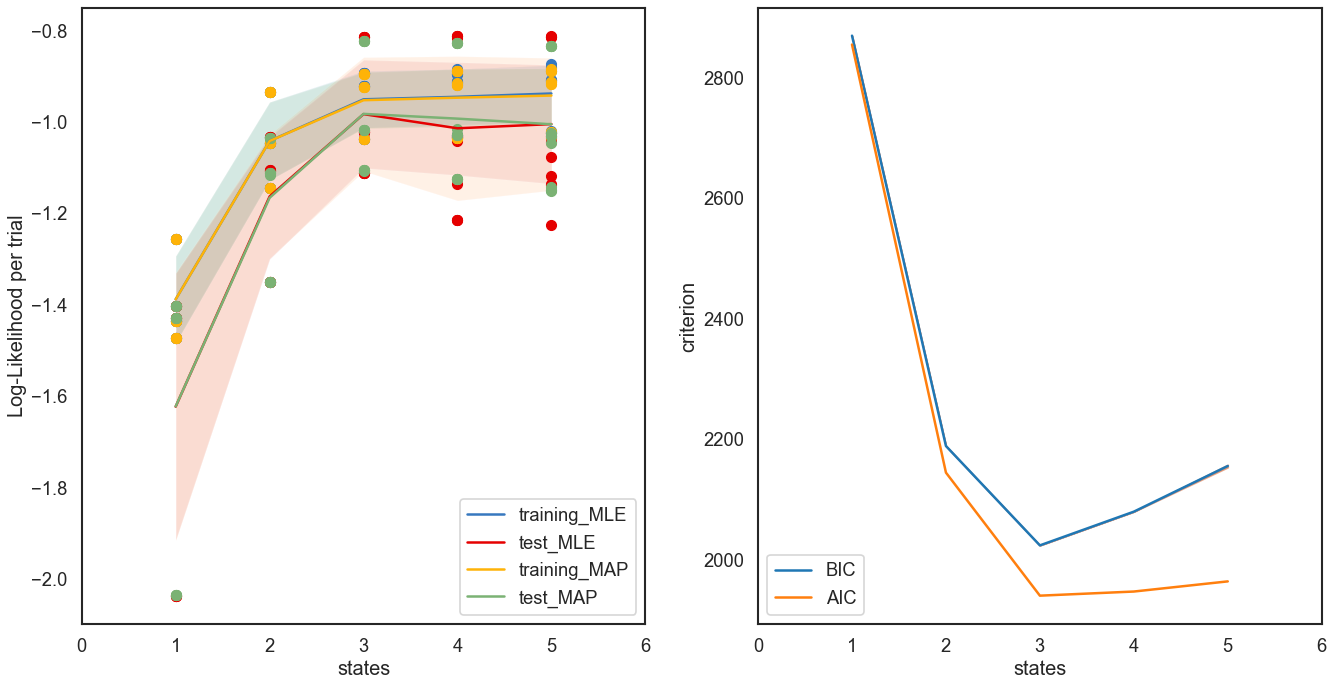

In [47]:
from scipy.interpolate import interp1d
kindspline='quadratic'
# Plot the xval loglik 
fig = plt.figure(figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 2, 1)

# reshape variables for plot
ll_training_plot = ll_training.reshape(max_states,nKfold*nRunEM)
ll_heldout_plot = ll_heldout.reshape(max_states,nKfold*nRunEM)
ll_training_map_plot = ll_training_map.reshape(max_states,nKfold*nRunEM)
ll_heldout_map_plot = ll_heldout_map.reshape(max_states,nKfold*nRunEM)


for iS, num_states in enumerate(range(1,max_states+1)):
    plt.plot((iS+1)*np.ones(nKfold*nRunEM),ll_training_plot[iS,:], color=colors[0], marker='o',lw=0)
    plt.plot((iS+1)*np.ones(nKfold*nRunEM),ll_heldout_plot[iS,:], color=colors[1], marker='o',lw=0)
    plt.plot((iS+1)*np.ones(nKfold*nRunEM),ll_training_map_plot[iS,:], color=colors[2], marker='o',lw=0)
    plt.plot((iS+1)*np.ones(nKfold*nRunEM),ll_heldout_map_plot[iS,:], color=colors[3], marker='o',lw=0)

x=range(1,max_states+1)
y=ll_training_plot.mean(axis=1); error=ll_training_plot.std(axis=1)
plt.plot(x,y, label="training_MLE", color=colors[0])
plt.fill_between(x,y-error, y+error,alpha=0.1)
#
y=ll_heldout_plot.mean(axis=1); error=ll_heldout_plot.std(axis=1)
plt.plot(x,y, label="test_MLE", color=colors[1])
plt.fill_between(x,y-error, y+error,alpha=0.1)
#
y=ll_training_map_plot.mean(axis=1); error=ll_training_map_plot.std(axis=1)
plt.plot(x,y, label="training_MAP", color=colors[2])
plt.fill_between(x,y-error, y+error,alpha=0.1)
#
y=ll_heldout_map_plot.mean(axis=1); error=ll_heldout_map_plot.std(axis=1)
plt.plot(x,y, label="test_MAP", color=colors[3])
plt.fill_between(x,y-error, y+error,alpha=0.1)
plt.legend(loc="lower right")
plt.xlabel("states")
plt.xlim(0, max_states+1)
plt.ylabel("Log-Likelihood per trial")

plt.subplot(1, 2, 2)

x=range(1,max_states+1); 
y=np.mean(BIC,1); error=np.std(BIC,1)
plt.plot(x,y, label="BIC")
plt.fill_between(x, y-error, y+error,
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
y=np.mean(AIC,1); error=np.std(AIC,1)
plt.plot(x,y, label="AIC")
plt.xlabel("states")
plt.xlim(0, max_states+1)
plt.ylabel("criterion")
plt.legend(loc="lower left")


savefile= 'HMM_model_sel_concAllBouts.pdf'
plt.savefig(savefile, format="pdf", bbox_inches="tight")
# plt.close(fig) 
plt.show()

model_sel={'ll_training':ll_training,'ll_heldout':ll_heldout,'ll_training_map':ll_training_map,'ll_heldout_map':ll_heldout_map,'BIC':BIC}


  0%|          | 0/50 [00:00<?, ?it/s]

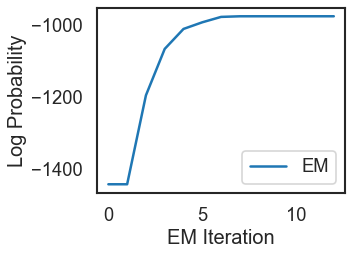

In [ ]:
num_states=3
obs_dim=1
input_dim=1
mle_hmm = ssm.HMM(num_states, obs_dim, M=input_dim, observations="input_driven_obs_gaussian", transitions="standard")

obs=y_new.reshape(-1,1)
inpt=X_new.reshape(-1,1)
N_iters = 50 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll = mle_hmm.fit(obs, inputs=inpt, method="em", num_iters=N_iters, tolerance=10**-4)

# Plot the log probabilities of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll, label="EM")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
# plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

trans
 [[0.98643137 0.00915789 0.00441074]
 [0.01280692 0.96571213 0.02148095]
 [0.01389427 0.01618687 0.96991886]]
mus
 [[-0.97725113]
 [ 1.01844628]
 [-0.2282434 ]]
Wks
 [[[ 2.93739095]]

 [[-3.12234138]]

 [[ 0.49473308]]]
Sigmas
 [[[0.48480645]]

 [[0.5213622 ]]

 [[0.88851141]]]


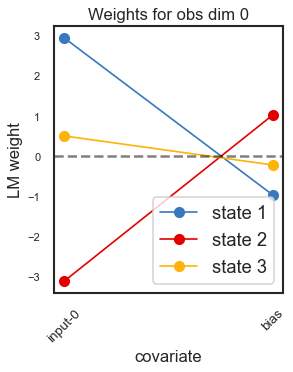

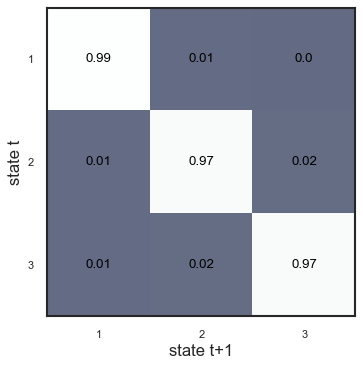

In [ ]:
# Plot fit parameters:
mus=mle_hmm.observations.mus
gen_weights=mle_hmm.observations.Wks
sigmas=np.sqrt(mle_hmm.observations.Sigmas)
trans0=np.exp(mle_hmm.transitions.log_Ps)
print('trans\n',trans0)
print('mus\n',mus)
print('Wks\n',gen_weights)
print('Sigmas\n',sigmas)

utilplot.plot_weights(gen_weights,mus)
# if save_figures:
#     plt.savefig("hmm_params.pdf")
    
fig = plt.figure(figsize=(5, 5), dpi=80, facecolor='w', edgecolor='k')
utilplot.plot_trans_matrix(trans0)

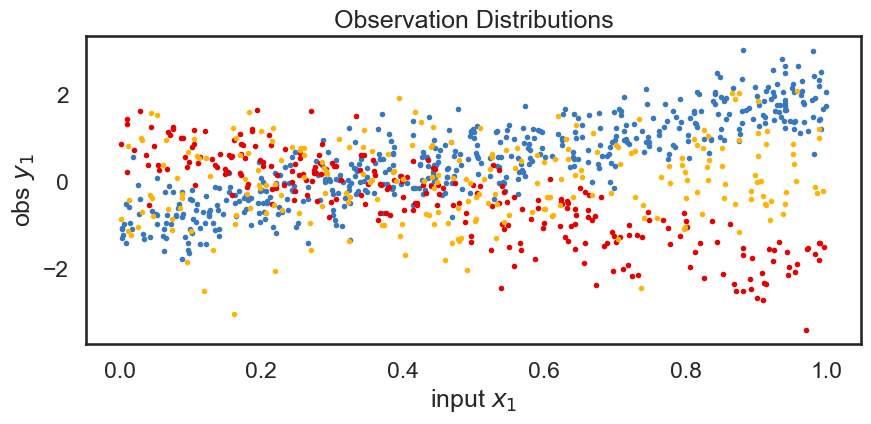

In [ ]:
most_likely_states=mle_hmm.most_likely_states(obs, input=inpt)
plt.figure(figsize=(10, 4))
for k in range(num_states):
    plt.plot(inpt[most_likely_states==k,0], obs[most_likely_states==k, 0], 'o',linestyle='', mfc=colors[k], mec='none', ms=4,label=f"State {k+1}")
    
# r2
pred_obs=np.zeros_like(obs)
# for k in range(num_states):
#     pred_obs[most_likely_states==k]=inpt[most_likely_states==k,:]*gen_weights[k]+mus[k]
pred_w=np.matmul(posterior_probs,gen_weights.reshape(num_states,-1)).reshape(n_samples,obs_dim,input_dim)
pred_wx = np.einsum('ijk,ik->ij', pred_w, inpt)
pred_obs=pred_wx+np.matmul(posterior_probs,mus.reshape(num_states,-1)).reshape(-1,obs_dim)
r2=r2_score(obs, pred_obs)

# plt.plot(inpt[:,0], obs[:,0], '-k', lw=1, alpha=.25)
plt.xlabel("input $x_1$")
plt.ylabel("obs $y_1$")
plt.title("Observation Distributions")

if save_figures:
    plt.savefig("hmm_1.pdf")

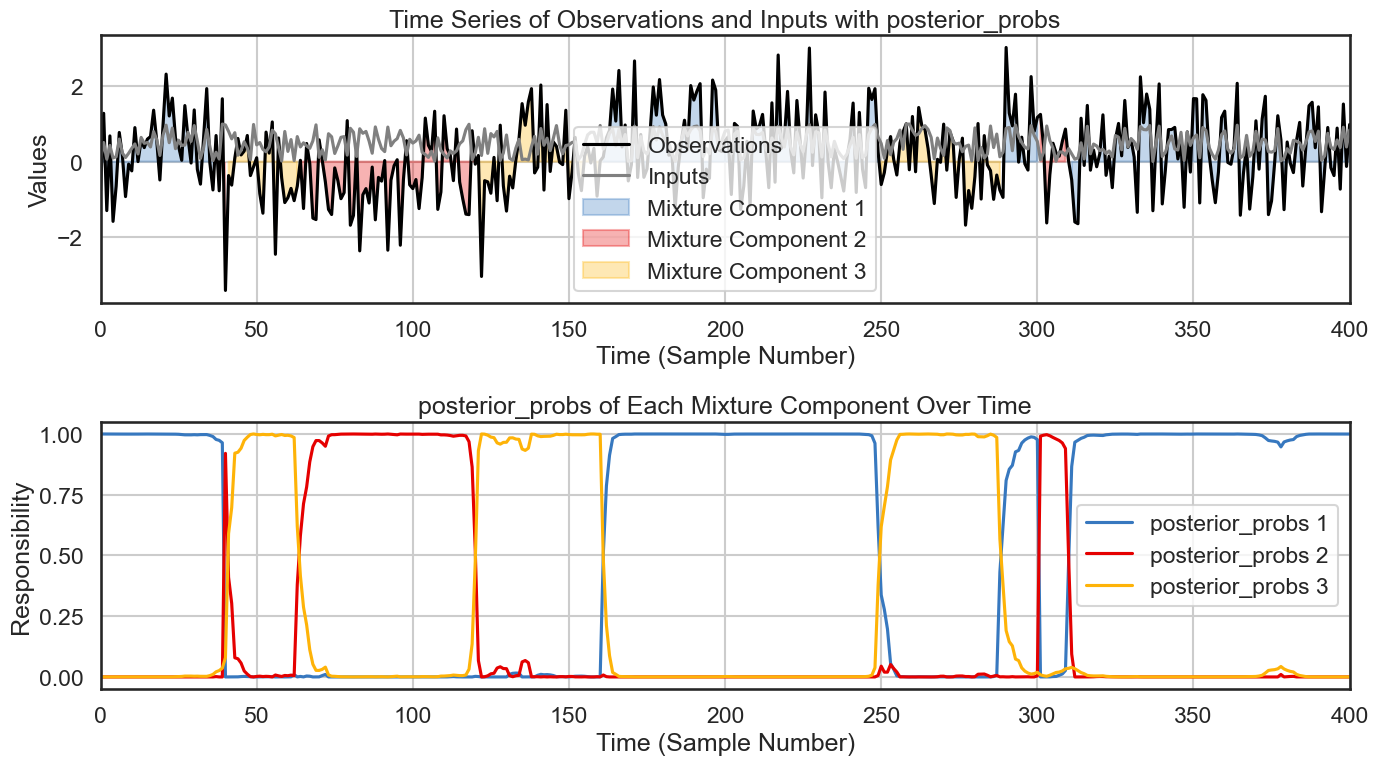

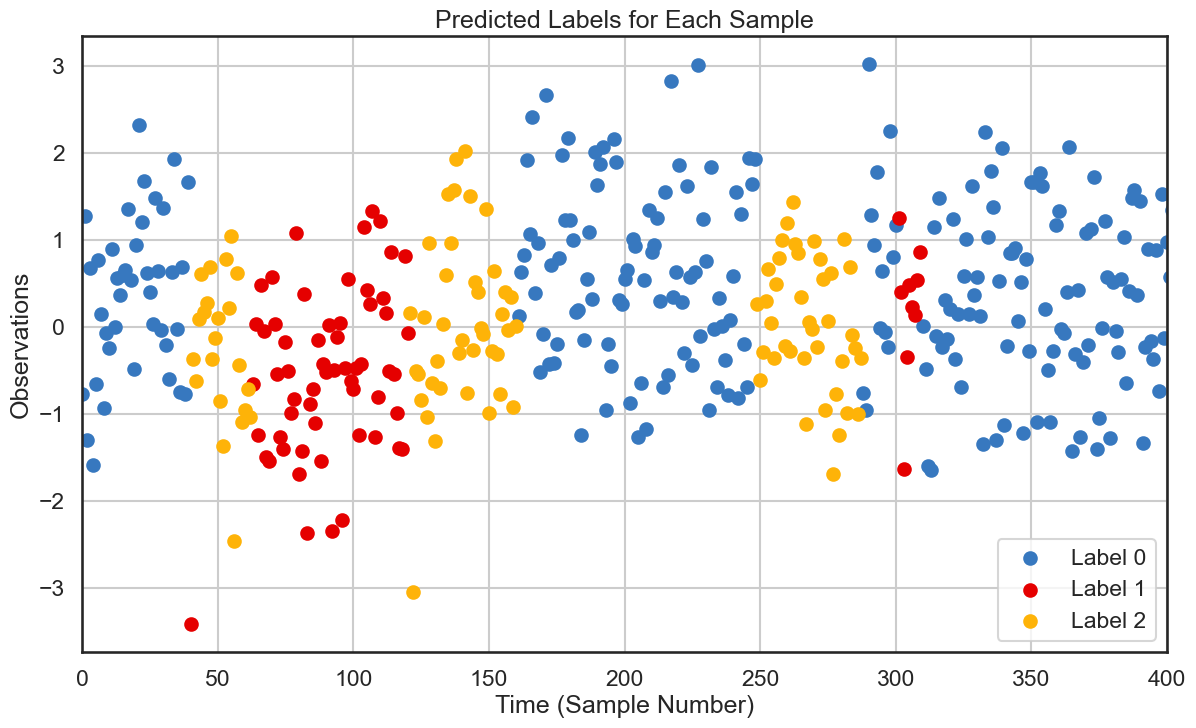

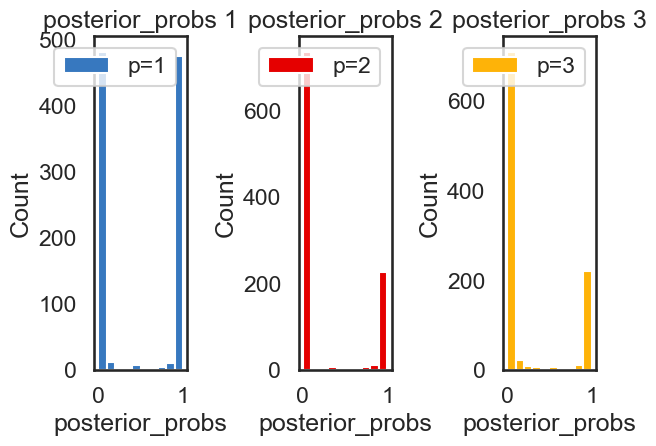

In [ ]:
# Predict responsibilities and labels
posterior_probs = mle_hmm.expected_states(data=obs, input=inpt)[0]
predicted_labels = most_likely_states
xlim=400

# Fit the model to the generated data
n_components=num_states
# Plot the time series of the data (obs and inputs)
plt.figure(figsize=(14, 8))
n_samples = len(y)
# Plot observations and inputs
plt.subplot(2, 1, 1)
plt.plot(range(n_samples), y, label='Observations', color='black')
plt.plot(range(n_samples), X.flatten(), label='Inputs', color='gray')

for i in range(n_components):
    plt.fill_between(range(n_samples), y, where=(posterior_probs[:, i] > 0.5), color=colors[i], alpha=0.3, label=f'Mixture Component {i+1}')

plt.xlabel('Time (Sample Number)')
plt.ylabel('Values')
plt.title('Time Series of Observations and Inputs with posterior_probs')
plt.xlim(0,xlim)

plt.legend()
plt.grid(True)

# Plot posterior_probs
plt.subplot(2, 1, 2)
for i in range(n_components):
    plt.plot(range(n_samples), posterior_probs[:, i], label=f'posterior_probs {i+1}', color=colors[i])

plt.xlabel('Time (Sample Number)')
plt.ylabel('Responsibility')
plt.title('posterior_probs of Each Mixture Component Over Time')
plt.xlim(0,xlim)

plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Visualize the predicted labels

plt.figure(figsize=(14, 8))
indplot = np.arange(n_samples)
for i in range(n_components):
    mask = (predicted_labels == i)
    plt.scatter(indplot[mask], y[mask], color=colors[i], label=f'Label {i}')
plt.xlabel('Time (Sample Number)')
plt.ylabel('Observations')
plt.title('Predicted Labels for Each Sample')
plt.xlim(0,xlim)

plt.legend()
plt.grid(True)
plt.show()

for i in range(posterior_probs.shape[1]):
    plt.subplot(1,posterior_probs.shape[1],  i+1)
    plt.hist(posterior_probs[:, i], color=colors[i], label=f'p={i+1}')
    plt.legend()
    plt.title(f'posterior_probs {i+1}')
    plt.xlabel('posterior_probs'); plt.ylabel('Count')

plt.tight_layout()
plt.show()



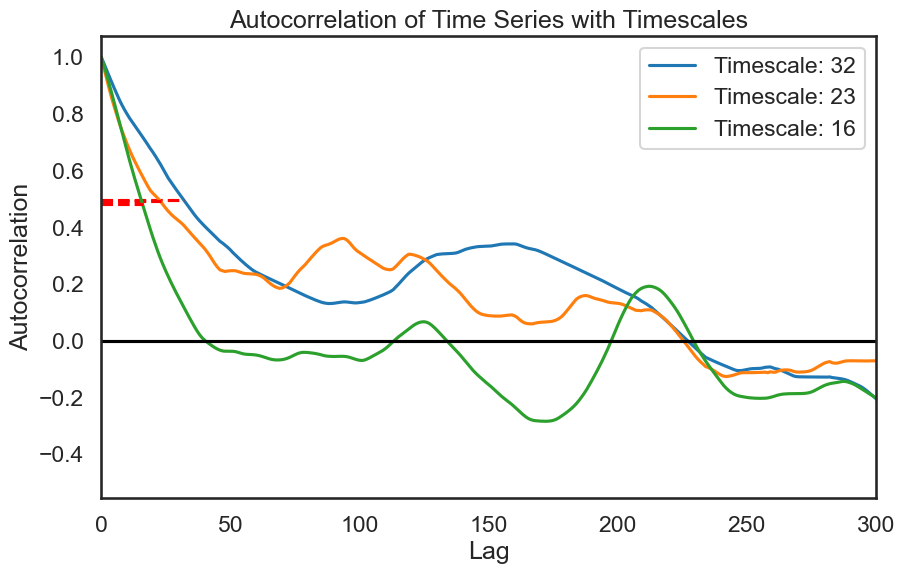

<Figure size 640x480 with 0 Axes>

In [ ]:
fig=plt.figure(figsize=(10, 6))
xlim=300
timescale = []
for i in range(n_components):
          y_acf=utils_tutorial.autocovariance(posterior_probs[:,i])
          y_acf=y_acf[2:]/np.max(y_acf[2:])
          timescale.append( int(utils_tutorial.compute_hwhm(y_acf)))
          plt.plot(y_acf, label=f"Timescale: {timescale[i]}")
          plt.axhline(y_acf[timescale[i]], xmin=0, xmax=(timescale[i])/xlim, color='red', linestyle='--')
plt.axhline(0, color='black')
plt.legend()
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of Time Series with Timescales")
plt.xlim([0, xlim])
plt.show()
plt.savefig('AutocorrTimescales.png')

# Bonus material

## 2.d Maximum A Posteriori (MAP) estimation

Above, we performed Maximum Likelihood Estimation to retrieve the generative parameters of the LM-HMM. If the number of trials is small, it is useful to introduce a prior distribution on the model parameters and perform Maximum A Posteriori (MAP) estimation. The relative weight of the prior compared to the likelihood decreases as the sample size increases, so that for very large sample size the MAP and MLE estimations should converge. For small sample size, however, the MAP estimation will significantly differ from the MLE in the direction of the constraints imposed by the chosen prior distributions on the weights. The prior we consider for the LM-HMM is the product of a Gaussian prior on the LM weights, and a Dirichlet prior on the transition matrix, :

 The prior we consider for the LM-HMM is the product of a Gaussian prior on the LM weights, $W$, and a Dirichlet prior on the transition matrix, $A$:

$$
\begin{align}
\Pr(W,A) &= {\it N}(W|0, \Sigma)Dir(A|\alpha) \\&= {\it N}(W|0, diag(\sigma^{2}, \cdots, \sigma^{2})) \prod_{j=1}^{K} \dfrac{1}{B(\alpha)} \prod_{k=1}^{K} A_{jk}^{\alpha -1}
\end{align}
$$

There are two hyperparameters controlling the strength of the prior: $\sigma$ and $\alpha$.  The larger the value of $\sigma$ and if $\alpha = 1$, the more similar MAP estimation will become to Maximum Likelihood Estimation, and the prior term will become an additive offset to the objective function of the LM-HMM that is independent of the values of $W$ and $A$.  In comparison, setting $\sigma = 2$ and $\alpha = 2$ will result in the prior no longer being independent of $W$ and $\alpha$.  

In order to perform MAP estimation for the GLM-HMM with `ssm`, the new syntax is:

```python
map_hmm = ssm.HMM(num_states, obs_dim, M=input_dim, 
          observations="input_driven_obs_gaussian", 
          observation_kwargs=dict(prior_sigma=prior_sigma),
          transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))
```

where `prior_sigma` is the $\sigma$ parameter from above, and `prior_alpha` is the $\alpha$ parameter.

  0%|          | 0/10000 [00:00<?, ?it/s]

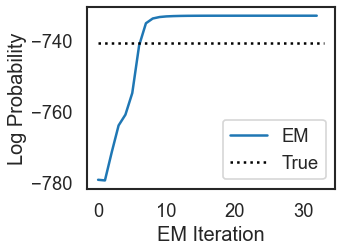

In [14]:
prior_sigma = 1
prior_alpha = 1

map_hmm = ssm.HMM(num_states, obs_dim, M=input_dim, 
          observations="input_driven_obs_gaussian", 
          observation_kwargs=dict(prior_sigma=prior_sigma),
          transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))

N_iters = 10000 # maximum number of EM iterations. Fitting with stop earlier if increase in LL is below tolerance specified by tolerance parameter
fit_ll_map = map_hmm.fit(obs, inputs=inpt, method="em", num_iters=N_iters, tolerance=10**-6)

# match states with ground truth
most_likely_states_map=map_hmm.most_likely_states(obs, input=inpt)
map_hmm.permute(find_permutation(true_states, most_likely_states_map))

# Plot the log likelihood of the true and fit models. Fit model final LL should be greater 
# than or equal to true LL.
fig = plt.figure(figsize=(4, 3), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fit_ll_map, label="EM")
plt.plot([0, len(fit_ll_map)], (true_ll) * np.ones(2), ':k', label="True")
plt.legend(loc="lower right")
plt.xlabel("EM Iteration")
# plt.xlim(0, len(fit_ll))
plt.ylabel("Log Probability")
plt.show()

Compare true likelihood with MLE and MAP.

Text(0, 0.5, 'loglikelihood')

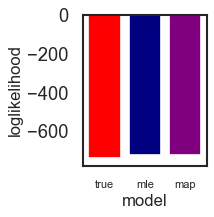

In [17]:
true_likelihood = true_hmm.log_likelihood(obs, inputs=inpt)
mle_final_ll = mle_hmm.log_likelihood(obs, inputs=inpt) 
map_final_ll = map_hmm.log_likelihood(obs, inputs=inpt) 
# Plot these values
fig = plt.figure(figsize=(2, 2.5), dpi=80, facecolor='w', edgecolor='k')
loglikelihood_vals = [true_likelihood, mle_final_ll, map_final_ll]
colors_ll = ['Red', 'Navy', 'Purple']
for z, occ in enumerate(loglikelihood_vals):
    plt.bar(z, occ, width = 0.8, color = colors_ll[z])
plt.xticks([0, 1, 2], ['true', 'mle', 'map'], fontsize = 10)
plt.xlabel('model', fontsize = 15)
plt.ylabel('loglikelihood', fontsize=15)

Compare recovered parameters with MLE and MAP estimation.

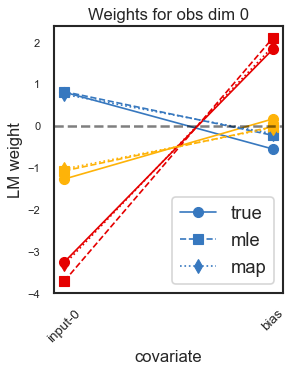

In [18]:
# Plot generative parameters:
mus=true_hmm.observations.mus
a=true_hmm.observations.Wks
recovered_weights_mle = mle_hmm.observations.Wks
recovered_mus_mle=mle_hmm.observations.mus
recovered_weights_map = map_hmm.observations.Wks
recovered_mus_map=map_hmm.observations.mus


weight_dic={}; weight_dic[0]={}; weight_dic[1]={};  weight_dic[2]={}; 
weight_dic[0]['weights']=gen_weights; weight_dic[0]['mus']=mus; weight_dic[0]['label']='true'; 
weight_dic[1]['weights']=recovered_weights_mle; weight_dic[1]['mus']=recovered_mus_mle; weight_dic[1]['label']='mle'; 
weight_dic[2]['weights']=recovered_weights_map; weight_dic[2]['mus']=recovered_mus_map; weight_dic[2]['label']='map'; 
utilplot.plot_weights_comparison(weight_dic)